# Creating the Delaney dataset

Task: calculating the ESOL (solvation energy) predicted or measured from the data. This dataset comes with some features already. I'll add the extras in, we can chose to use them or not later. Is a nice regression task. 

Idea to try: each time you get a conformer, the conformer is in a slightly different place. So lets do 60 unwrappings of the first conformer, and do 60 unwrappings of a different conformer each time? Perhaps as two datasets for ease of use? I think as two datasets atm, for ease of not making a mistake with the dataset

Hopefully, this task requires some sort of shape information

In [34]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot
import matplotlib.tri 
import rdkit.Chem
import rdkit.Chem.AllChem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
import mpl_toolkits.mplot3d
import operator
import functools
import os
import gif
import h5py
import scipy.linalg
import slugify

from skspatial.objects import Point, Vector, Triangle
from operator import attrgetter
from scipy.constants import golden
from IPython.display import HTML

from projection.Molecule import Molecule
import projection
from projection.ico import Ico

In [35]:
save_dir=r'C:\Users\ella_\Nextcloud\science\Datasets'
data_dir=r'C:\Users\ella_\Nextcloud\science\Datasets'
input_file='delaney-processed.csv'
input_file_location=os.path.join(data_dir, input_file)
df = pd.read_csv(input_file_location)
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


#### Test one of the molecules

Compound ID    Picene
Name: 3, dtype: object


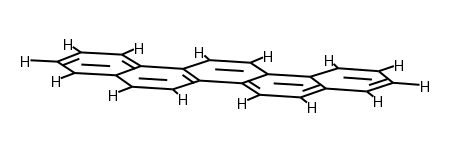

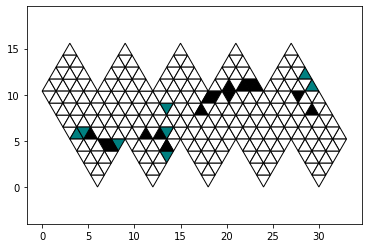

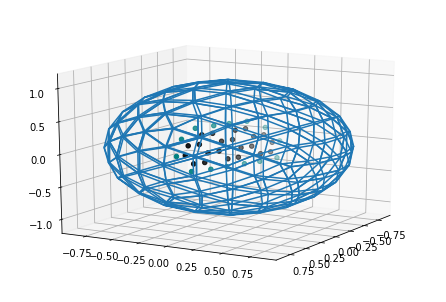

In [41]:
idx=3
print(df[['Compound ID']].iloc[idx])
# This optimises and does adds Hs, also rotates and centers the molecule
m=Molecule(df[['smiles']].iloc[idx][0])
# creates the ico projection object
i = Ico(m,2)
# draws a 2D unfolding
i.draw2D()
# draws a 3D unfolding
i.draw3D()
# gives the chemical structure in standard format
m.molecule